In [13]:
import pandas as pd
import seaborn as sns
from linearmodels import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from fixedeffect.fe import fixedeffect
import matplotlib.ticker as mtick
from collections import defaultdict
import matplotlib.dates as mdates
import warnings
plt.style.use('seaborn-v0_8-deep')

warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)

In [14]:
original_df = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)
original_df.reset_index(inplace=True,drop=True)
original_df['error'] = 0
original_df['tournament'] = original_df['tournament'].astype('category').cat.codes

# Create a new column that combines 'tournament' and 'year' into a single string
original_df['tournament_and_year'] = original_df['year'].astype(str) + '_' + original_df['tournament'].astype(str)
# Convert the new 'tournament_and_year' column to categorical and get its codes
original_df['tournament_and_year'] = original_df['tournament_and_year'].astype('category').cat.codes

# Set the 'error' column values based on the conditions
original_df.loc[original_df['outcome'] == 1, 'error'] = 1 - original_df['inverse_avg']
original_df.loc[original_df['outcome'] != 1, 'error'] = 0 - original_df['inverse_avg']


fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))
df = fitset

Fit set rows: 15854
Test set rows: 5190


In [49]:
import pandas as pd
from linearmodels.iv import IV2SLS

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create the dummy variable based on the date being before 2016-07-02
cutoff_date = pd.Timestamp('2016-01-02')
df['Player_Wiki_Profile_Young'] = (df['date'] < cutoff_date).astype(int)
df['Player_Wiki_Profile_Old'] = (df['date'] >= cutoff_date).astype(int)
# Create interaction terms
interaction_vars = []
for var in ['wikibuzz', 'rankdist', 'inverse_avg']:
    interaction_term = f'{var}_Wiki_Young'
    df[interaction_term] = df[var] * df['Player_Wiki_Profile_Young']
    interaction_vars.append(interaction_term)
    
    # interaction_term = f'{var}_Wiki_Old'
    # df[interaction_term] = df[var] * df['Player_Wiki_Profile_Old']
    # interaction_vars.append(interaction_term)

# Define the model formula with interaction terms
formula = 'error ~ inverse_avg + rankdist + wikibuzz + C(year) + ' + ' + '.join(interaction_vars)
#formula = 'error ~ inverse_avg + rankdist + wikibuzz + C(year)'
# Fit the model using IV2SLS
mod = IV2SLS.from_formula(formula, df)
resid = mod.fit(cov_type='clustered', clusters=df[['tournament_and_year', 'match_id']])

# Print the summary
print(resid)


                            OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0012
Estimator:                        OLS   Adj. R-squared:                 0.0006
No. Observations:               15854   F-statistic:                    240.42
Date:                Thu, Nov 16 2023   P-value (F-stat)                0.0000
Time:                        12:03:48   Distribution:                  chi2(9)
Cov. Estimator:             clustered                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Intercept                 -0.0169     0.0404    -0.4181     0.6759     -0.0962      0.0624
inve

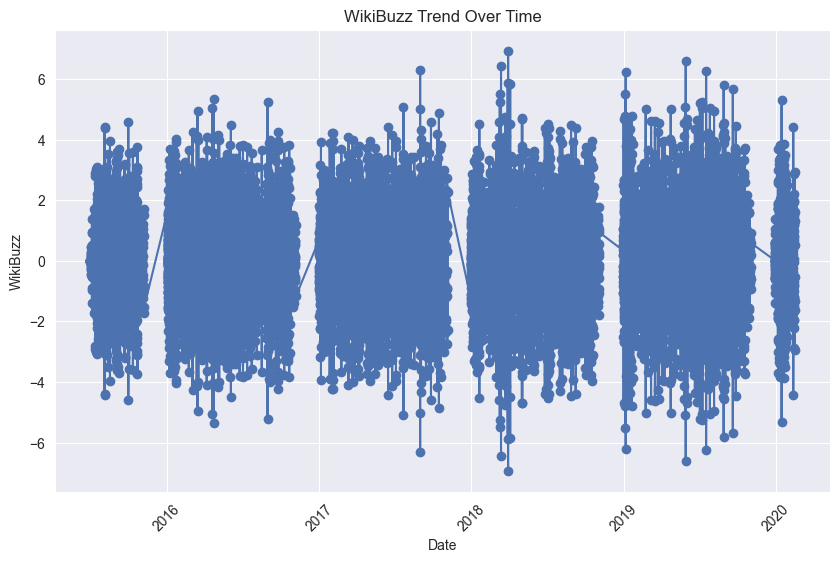

In [8]:
# Convert date from string to datetime
df['date'] = pd.to_datetime(df['date'])

# Plotting
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['wikibuzz'], marker='o')
plt.xlabel('Date')
plt.ylabel('WikiBuzz')
plt.title('WikiBuzz Trend Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
# Filter the DataFrame to include only months from July to December
df_filtered = df[df['date'].dt.month.between(7, 12)]

# Group by year and calculate the sum of the absolute values of 'wikibuzz'
absolute_sum_per_year = df_filtered.groupby(df_filtered['date'].dt.year)['wikibuzz'].apply(lambda x: np.sum(np.abs(x)))

# Calculate the variance of 'wikibuzz' for each year
variance_per_year = df_filtered.groupby(df_filtered['date'].dt.year)['wikibuzz'].var()

# Results
print("Absolute Sum Per Year:", absolute_sum_per_year)
print("Variance Per Year:", variance_per_year)

Absolute Sum Per Year: date
2015    1789.096990
2016    1768.919527
2017    2092.546813
2018    2086.829378
2019    2329.859535
Name: wikibuzz, dtype: float64
Variance Per Year: date
2015    1.474965
2016    1.619334
2017    1.930083
2018    1.889307
2019    2.441195
Name: wikibuzz, dtype: float64


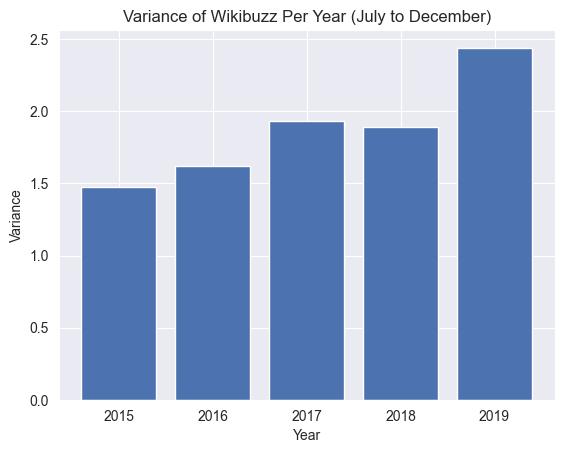

In [12]:
# Plotting the variance per year as a bar chart
plt.bar(variance_per_year.index, variance_per_year)
plt.title('Variance of Wikibuzz Per Year (July to December)')
plt.xlabel('Year')
plt.ylabel('Variance')
plt.show()

